In [ ]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf # only for tf_v1
import matplotlib.pyplot as plt
import numpy as np

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\siddh\miniconda3\envs\baseml\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-9493ebc4d3a8>", line 4, in <module>
    from tensorflow.examples.tutorials.mnist import input_data
  File "C:\Users\siddh\miniconda3\envs\baseml\lib\site-packages\tensorflow_core\examples\tutorials\mnist\__init__.py", line 21, in <module>
    from tensorflow.examples.tutorials.mnist import input_data
  File "C:\Users\siddh\miniconda3\envs\baseml\lib\site-packages\tensorflow_core\examples\tutorials\mnist\input_data.py", line 30, in <module>
    from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
  File "C:\Users\siddh\miniconda3\envs\baseml\lib\site-packages\tensorflow\__init__.py", line 50, in __getattr__
    module = self._load()
  File "C:\Users\siddh\miniconda3\envs\baseml\lib\site-packages\tensorflow\__init__.py", line 44,

In [1]:
# Training Parameters
learning_rate = 0.001
num_steps = 700
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.50 # Dropout, probability to drop a unit

ERROR! Session/line number was not unique in database. History logging moved to new session 288


In [5]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # 1st Convolution Layer with 32 filters and a kernel(filter) size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # 2nd Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [6]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [7]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SIDDHE~1\\AppData\\Local\\Temp\\tmpbibf49cb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EC009C36A0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dropout instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\SIDDHE~1\AppData\Local\Temp\tmpbibf49cb\model.ckpt.
INFO:tensorflow:loss = 2.3400383, step = 1
INFO:tensorflow:global_step/sec: 10.5669
INFO:tensorflow:loss = 0.124905676, step = 101 (9.472 sec)
INFO:tensorflow:global_step/sec: 8.2496
INFO:tensorflow:loss = 0.053447843, step = 201 (12.117 sec)
INFO:tensorflow:global_step/sec: 9.79158
INFO:tensorflow:loss = 0.06551696, step = 301 (10.214 sec)
INFO:tensorflow:global_step/sec: 9.68571
INFO:tensorflow:loss = 0.061011016, step = 401 (10.324 sec)
INFO:ten

In [9]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-08-21T16:50:43Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\SIDDHE~1\AppData\Local\Temp\tmpbibf49cb\model.ckpt-700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-08-21-16:50:46
INFO:tensorflow:Saving dict for global step 700: accuracy = 0.9845, global_step = 700, loss = 0.050595265
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 700: C:\Users\SIDDHE~1\AppData\Local\Temp\tmpbibf49cb\model.ckpt-700


{'accuracy': 0.9845, 'loss': 0.050595265, 'global_step': 700}

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\SIDDHE~1\AppData\Local\Temp\tmpbibf49cb\model.ckpt-700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


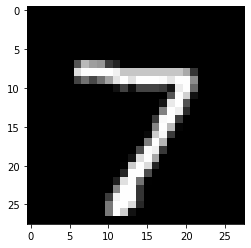

Model prediction: 7


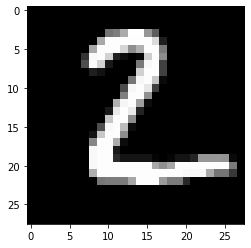

Model prediction: 2


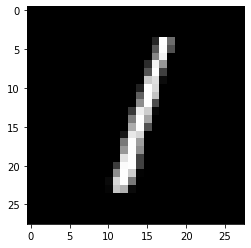

Model prediction: 1


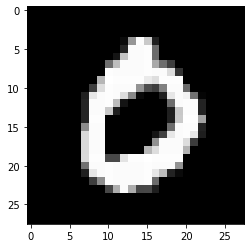

Model prediction: 0


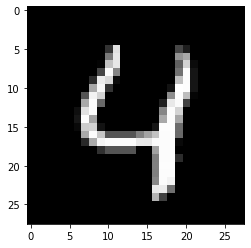

Model prediction: 4


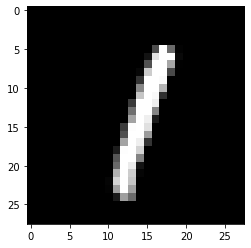

Model prediction: 1


In [10]:
# Predict single images
n_images = 6
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])